<a href="https://colab.research.google.com/github/HenrySomeCode/Predicting-Stock-Using-LSTM/blob/main/Predicting_Stock_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref:
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Part I: Theory

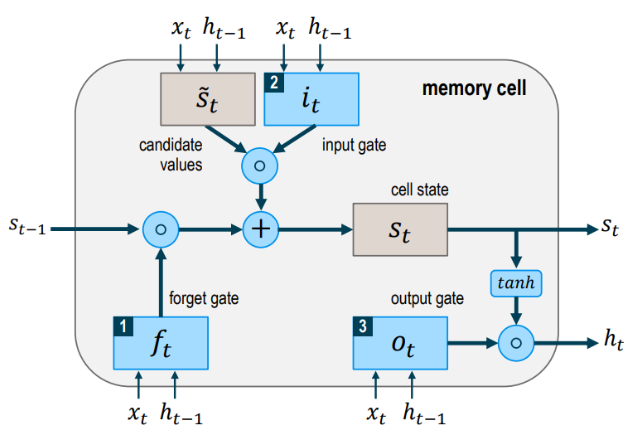

[Source: https://www.researchgate.net/figure/The-architecture-of-LSTM-memory-block-17_fig2_328635139 ]

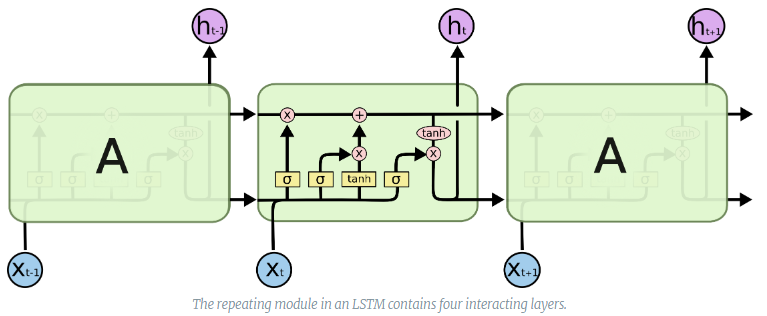

[Source: https://www.researchgate.net/figure/Long-Short-Term-Memory-LSTM-has-three-layers-as-forget-gate-layer-input-gate-layer-and_fig1_337241326 ]

# Part II: Building An LSTM Model From Scratch by Youssef Hosni

Note: Although it took more than a half day to understaand most of the post by Youssef Hosni, this part is only for understanding how LSTM works in terms of coding. It will not be used in Part III.

[Ref: https://pub.towardsai.net/building-a-lstm-from-scratch-in-python-1dedd89de8fe ]

This part references a post by Youssef Hosni. It's a member-only story, but it's my luck to have permission to read it though I don't register Medium membership yet. The reason that I can access this article is through a link provided by himself on this post: https://www.linkedin.com/posts/youssef-hosni-b2960b135_building-an-lstm-model-from-scratch-in-python-activity-7016644804159647744-yC-B/?originalSubdomain=tz

It really feels like some kind of magic to me as the first time to read a member-only post on Medium ! :>

Forward Propagation

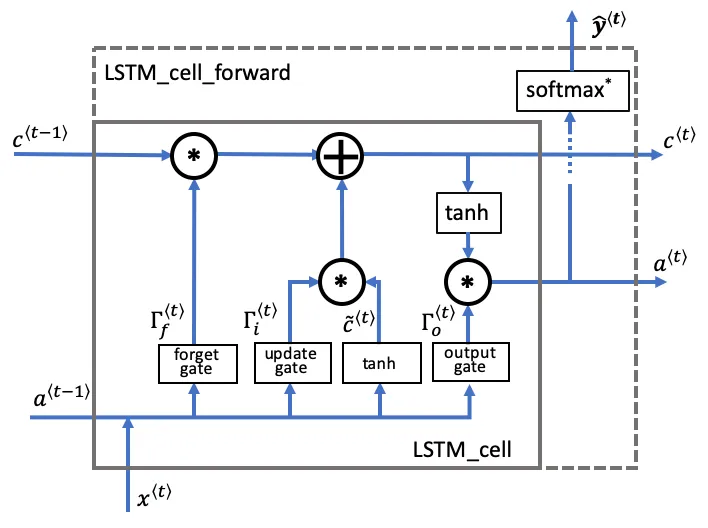

In [ ]:
import numpy as np

In [ ]:
from scipy.special import softmax

In [ ]:
def sigmoid (x):
    return 1/(1+np.exp(-x))

In [ ]:
def lstm_cell_forward (xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell

    Arguments:
    xt -- input data ar timestep t, numpy array of shape (n_x, m)
    a_prev -- hidden state at timestep t-1, also known short-term memory,
    numpy array, of shape (n_a, m)
    c_prev -- memory state at timestep t-1, also know long-term memory,
    numpy_array, of shape (n_a,m)
    parameters -- python dictionary type, contains:  Wf,bf, Wi, bi, Wc,bc,Wo,bo, Wy, by
    """

    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]

    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    concat = np.concatenate((a_prev, xt), axis = 0)

    ft = sigmoid(np.dot(Wf, concat) + bf)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    it = sigmoid(np.dot(Wi, concat) + bi)
    c_next = ft*c_prev + it*cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot*np.tanh(c_next)

    yt_pred = softmax(np.dot(Wy, a_next) + by)

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [ ]:
def lstm_forward(x,a0,parameters):

    caches = []
    Wy = parameters['Wy']
    n_x, m, T_x = np.shape(x)
    n_y, n_a = np.shape(Wy)

    # a -- Hidden states for every time-step
    # c -- The value of the cell state
    # y -- Predictions for every time-step

    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))

    a_next = a0
    c_next = np.zeros((n_a, m))

    for t in range(T_x):
        xt = x[:,:,t]
        a_next, c_next, yt,cache = lstm_cell_forward(xt,a_next,c_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:,:,t] = a_next
        # Save the value of the next cell state
        c[:,:,t]  = c_next
        # Save the value of the prediction in y
        y[:,:,t] = yt
        # Append the cache into caches
        caches.append(cache)

    caches.append(cache,x)
    return a,y,c,caches

Backward Propagation

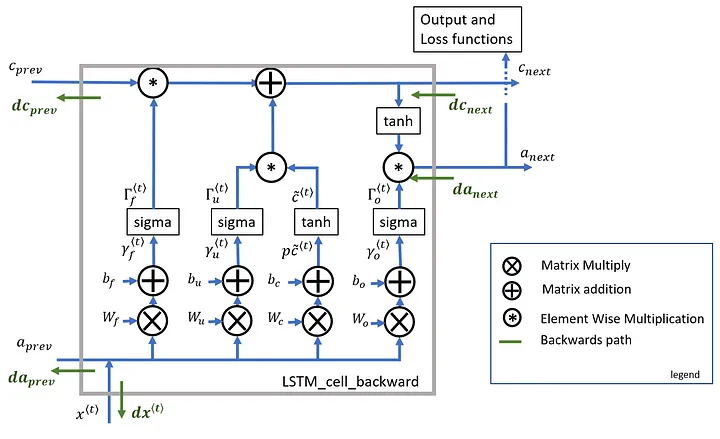

Gradients of Gates

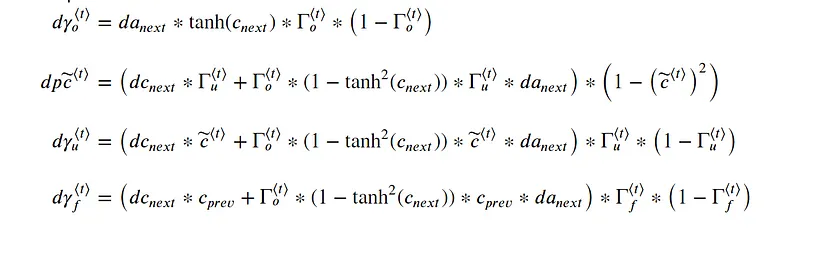

Gradients of Paramaters

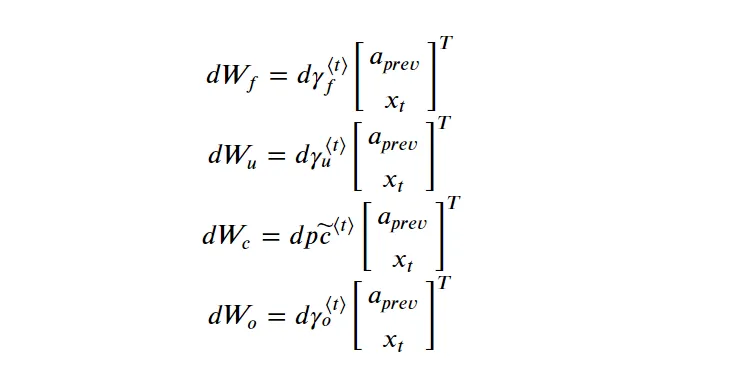

Gradients w.r.t. previous hidden state, same for previous memory state, previous input :

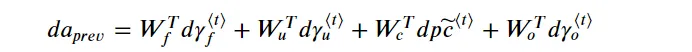

In [ ]:
def lstm_cell_backward(da_next, dc_next, cache):
  """
  Implement the backward pass for the LSTM-cell (a single time-step)

  Arguments:
  da_next -- gradients of next hidden state (at), shape is (n_a,m)
  dc_net -- gradients of next cell state (ct), shape is (n_a, m)
  cache -- storing information from forward propagation

  Returns:
  gradients -- python dictionary type, contains:
    dxt -- gradient of input data at time-step t, of shape (n_x, m)
    da_prev -- gradient w.r.t. the previous hidden state, numpy array,
    of shape (n_a, m)
    dc_pev -- gradient w.r.t. the previous cell state, numpy_array, of
    shape (n_a,m,T_x)
    dWf -- gradient w.r.t. weight matrix of the forget gate, numpy_array, of
    shape (n_a,n_a+n_x) #???
    dWi -- gradient w.r.t the weight matrix of update gate, numpy array of
    shape (n_a, n_a + n_x)
    dWc -- gradient w.r.t the weight matrix of memory gate (candidate),
    numpy array, of shape (n_a, n_a + n_x)
    dWo -- gradient w.r.t the weight matrix of the output gate, numpy array,
    of shape (na, n_a + n_x)
    dbf -- gradient w.r.t biases of the forget gate, of shape (n_a, 1)
    dbi -- gradient w.r.t biases of the update gate, of shape (n_a, 1)
    dbc -- gradient w.r.t biases of the memory gate, of shape (n_a, 1)
    dbo -- gradient w.r.t biases of the output gate, of shape (n_a, 1)

  Note:
  w.r.t. -- with respect to
  """

  (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

  n_x, m = xt.shape
  n_a, m = a_next.shape

  # Compute gradients of gates
  #dyu
  dit = (da_next * ot * (1 - np.tanh(c_next) ** 2)
                            + dc_next) * cct * (1 - it) * it
  #dyf
  dft = (da_next * ot * (1 - np.tanh(c_next) ** 2)
                            + dc_next) * c_prev * ft * (1 - ft)
  #dyo
  dot = da_next * np.tanh(c_next) * ot * (1 - ot)
  #dpc
  dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2)
                            + dc_next) * it * (1 - cct ** 2)

  # Compute gradients of paraneters
  dWf = np.dot(dft,np.concatenate((a_prev, xt), axis=0).T)
  dWi = np.dot(dit,np.concatenate((a_prev, xt), axis=0).T)
  dWc = np.dot(dcct,np.concatenate((a_prev, xt), axis=0).T)
  dWo = np.dot(dot,np.concatenate((a_prev, xt), axis=0).T)
  dbf = np.sum(dft,axis=1,keepdims=True)
  dbi = np.sum(dit,axis=1,keepdims=True)
  dbc = np.sum(dcct,axis=1,keepdims=True)
  dbo = np.sum(dot,axis=1,keepdims=True)

  # Compute derivatives w.r.t previous hidden state, previous memory state and input.
  da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft) # How do we get this formula by pure handwriting calculations?
  +np.dot(parameters['Wi'][:,:n_a].T,dit)
  +np.dot(parameters['Wc'][:,:n_a].T,dcct)
  +np.dot(parameters['Wo'][:,:n_a].T,dot)

  dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next #???

  dxt = np.dot(parameters['Wf'][:,n_a:].T,dft)
  +np.dot(parameters['Wi'][:,n_a:].T,dit)
  +np.dot(parameters['Wc'][:,n_a:].T,dcct)
  +np.dot(parameters['Wo'][:,n_a:].T,dot)

  # Save gradients in dictionary
  gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
              "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

  return gradients



In [ ]:
def lstm_backward(da,caches):

    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

    n_a, m, T_x = da.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))

     # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

# Part III : Predicting Stock Using LSTM

Ref:
* https://www.nguyentrieuphong.com/2021/07/LSTM-RNN-du-doan-co-phieu-.html

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        # data is cl which is 2D numpy array. So if we write data[i:(i+lb)],
        # this would return an 2D array. For the couple (data,label) or (X,Y)
        # we need 1D arrays. That's why we write data[i:(i+lb),0]
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

In [9]:
def stockpredict(stockName):
  #stockName = "AAL"
  data_path = '/content/gdrive/MyDrive/AI_ML_DL Course_by_Master_Linh_HUST/week4/Me/data/all_stocks_5yr.csv'
  data = pd.read_csv(data_path)
  cl = data[data['Name']==stockName].close #panda series
  #path = os.getcwd()
  # os.mkdir(path+"/static/stocks/"+stockName)

  # Standardlizing using MinMaxScaler -> [0,1]
  scl = MinMaxScaler()
  # MinMaxScaler function need 2D input.
  # That's why we need to convert cl (panda series - 1D) to 2D array.

  # cl.values = array([14.75, 14.46, 14.27, ..., 49.76, 51.18, 51.4 ])
  # cl.values.reshape(cl.shape[0],1) =
                                    # array([[14.75],
                                    #      [14.46],
                                    #      [14.27],
                                    #      ...,
                                    #      [49.76],
                                    #      [51.18],
                                    #      [51.4 ]])

  cl = cl.values.reshape(cl.shape[0],1)
  cl = scl.fit_transform(cl) #transform cl to range of [0,1]

  X,Y = processData(cl,7)
  X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
  Y_train,Y_test = Y[:int(Y.shape[0]*0.80)],Y[int(Y.shape[0]*0.80):]

  # building the RNN LSTM model
  # Sequential model. This "sequential" means that layers are put sequentially
  model = Sequential()
  model.add(LSTM(32,input_shape=(7,1)))
  #using drpout technique with probability 0f 0.5 to prevent over-fitting
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse')
  #Reshape data for (Sample,Timestep,Features)
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

  hist = model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test),shuffle=False)

  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.legend(['Loss', 'Validation Loss'], loc='upper right')
  plt.show()

  Xt = model.predict(X_test)
  rval = scl.inverse_transform(Y_test.reshape(-1,1))
  pval = scl.inverse_transform(Xt)

  plt.plot(rval)
  plt.plot(pval)
  plt.ylabel('Price')
  plt.xlabel('Days')
  plt.legend(['Real', 'Prediction'], loc='upper left')
  plt.show()

Epoch 1/50
32/32 [==============================] - 4s 41ms/step - loss: 0.0727 - val_loss: 0.0016
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0290 - val_loss: 0.0054
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0194 - val_loss: 0.0028
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0190 - val_loss: 0.0021
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0137 - val_loss: 0.0014
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0019
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0020
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0035
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0022
Epoch 11/50
32

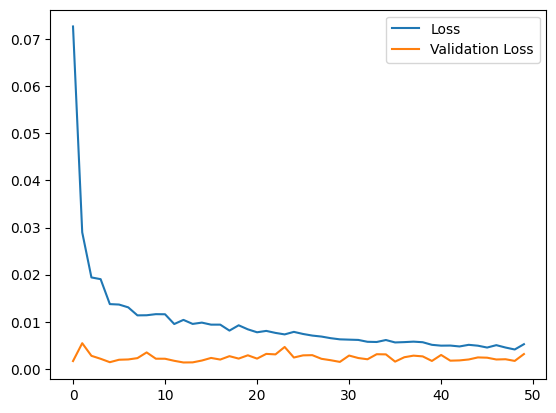

8/8 [==============================] - 0s 4ms/step


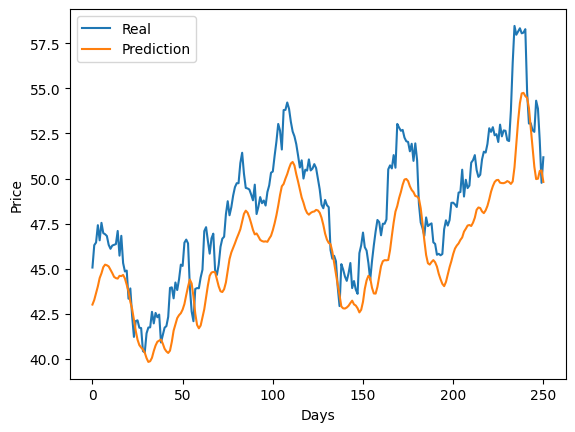

In [10]:
stockpredict("AAL")